In [138]:
import matplotlib.pyplot as plt
import pandas as pd

In [139]:
# константы
MARKET_UNIT_COST_ORGANIZATION = 26.402 # рыночная стоимость одного иска по организациям
MARKET_UNIT_COST_CITIZEN = 0.72907 # рыночная стоимость одного иска по гражданам
YEAR_NORMA_ORGANIZATION = 757 # годовой норматив подаваемых исков по организациям в одном регионе
YEAR_NORMA_CITIZEN = 47103 # годовой норматив подаваемых исков по гражданам в одном регионе

In [140]:
# модель расчёта расходов, выгоды, цены
def graf_cost(group='граждане', *cost):
    
    if group == 'граждане':
        market_unit_cost = MARKET_UNIT_COST_CITIZEN
    else:
        market_unit_cost = MARKET_UNIT_COST_ORGANIZATION
        
    resulting_costs = [] # список значений сумарных расходов в себестоимости
    market_costs = [x * market_unit_cost
                    for x in range(1, len(cost[0])+1)] # список значний суммарных расходов при закупки юруслуг на рынке 
    
    # формирование списока значений сумарных расходов в себестоимости
    # суммированием всех статей расходов
    for i in range(len(cost[0])):
        sum_cost = 0
        for j in range(len(cost)):
            sum_cost += cost[j][i]
        resulting_costs.append(sum_cost)
    # графики рыночных расходов и расходов в себестоимости
    plt.plot([x for x in range(1, len(market_costs)+1)], market_costs)
    plt.plot([x for x in range(1, len(resulting_costs)+1)], resulting_costs)
    
    
    
    return (market_costs, resulting_costs)

In [146]:
# класс расходов
class Cost:
    """
    Класс генерации списка значений расходов
    на количество судебных и исполнительных процессов
    от 1 до заданного количества
    
    Attributes
    ----------
    min_cost : float
        минимальные расходы не зависимо от количества исков, в руб.
    unit_cost : float
        удельные расходы на один иск, в руб./шт.
    max_lawsuit : int
        максимальное количесто исков, на которые расчитываются значения функции, шт.

    Methods
    -------
    cost_of_lawsuit() : list(float)
        Рассчёт списка значений для функции расходов
    """
    
    def __init__(self, group, min_cost, cost, max_lawsuit):
        """Инициализация параметров статьи расходов"""
        self.group = group
        self.min_cost = min_cost
        self.cost = cost
        self.max_lawsuit = max_lawsuit
        if self.group == 'граждане':
            self.norma = YEAR_NORMA_CITIZEN
        else:
            self.norma = YEAR_NORMA_ORGANIZATION
        self.unit_cost = self.cost / self.norma
    
    
    def cost_of_lawsuit(self):
        """
        Формирование списка значений функции расходов в зависимости от количества исков
        """
        def interval(x):
            if x > self.norma and self.min_cost !=0:
                return self.norma + (x - self.norma) / 2
            else:
                return x
        
        costs = [interval(x) * self.unit_cost
                 if x * self.unit_cost > self.min_cost
                 else self.min_cost
                 for x in range(1, self.max_lawsuit+1)]
        return costs
    

In [147]:
# Функция формирования расходов
def creat_costs(group, max_lawsuit, index_true):
    
    if group == 'граждане':
        fot = Cost(group, 0, 7411, max_lawsuit).cost_of_lawsuit()
        arenda = Cost(group, 0, 367, max_lawsuit).cost_of_lawsuit()
        hoz = Cost(group, 0, 6966, max_lawsuit).cost_of_lawsuit()
        material = Cost(group, 0, 1183, max_lawsuit).cost_of_lawsuit()
        manager = Cost(group, 3900, 7800, max_lawsuit).cost_of_lawsuit()
    else:
        fot = Cost(group, 0, 4941, max_lawsuit).cost_of_lawsuit()
        arenda = Cost(group, 0, 245, max_lawsuit).cost_of_lawsuit()
        hoz = Cost(group, 0, 4644, max_lawsuit).cost_of_lawsuit()
        material = Cost(group, 0, 30, max_lawsuit).cost_of_lawsuit()
        manager = Cost(group, 3900, 7800, max_lawsuit).cost_of_lawsuit()
        
    # считаем совокупную себестоимость и рыночную стоимость
    cost = graf_cost(group, fot, arenda, hoz, material, manager)
    
    # Формируем датафрейм значений функции
    df = pd.DataFrame({'Иски': [x for x in range(1, max_lawsuit+1)],
    'ФОТ': fot, 'Аренда': arenda, 'Хозяйственные': hoz,
    'Материальные': material, 'Менеджмент': manager,
    'ВСЕГО': cost[1], 'РЫНОЧНЫЕ': cost[0]
    })
    # Иски сделаем индексом
    df.set_index('Иски', inplace=True)
    # Рассчитаем выгоду и цену иска для каждого значения функции
    df['ВЫГОДА'] = df['РЫНОЧНЫЕ'] - df['ВСЕГО']
    df['ЦЕНА'] = df['ВСЕГО'] / df.index
    
    # сформируем датасет по заданным индексам
    #df_1 = df.loc[index_true]
    
    # запишем датасет в эксель файл на лист с названием в формате
    # группа_максимальное количество исков_количество значений(диапазон)
    sheet_name_out =\
        str(group)[:2].upper() + '_' + str(max_lawsuit) + 'ис_' +\
        str(len(index_true)) + '(' + str(index_true[0]) + '-' +\
        str(index_true[-1]) + ')'
    print('Лист:', sheet_name_out)
    with pd.ExcelWriter('Графики.xlsx', mode='a',
                    engine="openpyxl", if_sheet_exists="replace") as writer:
        df.loc[index_true].to_excel(writer, sheet_name=sheet_name_out)

Лист: ГР_47103ис_10(5000-47103)


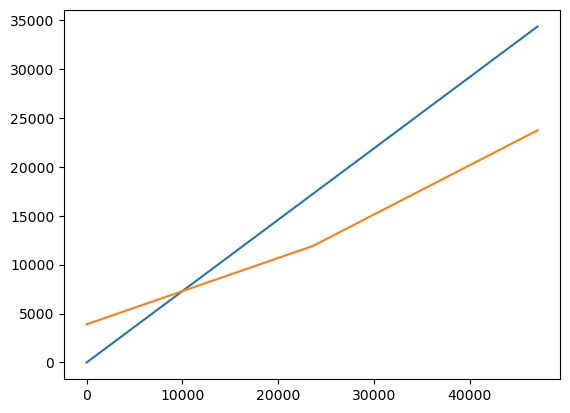

In [148]:
# Формирование расходов на 47 тыс. исков по гражданам
group = 'граждане'
max_lawsuit = 47103
index_true = [5000, 10000, 15000,
              20000, 25000, 30000,
              35000, 40000, 45000, 47103]

creat_costs(group, max_lawsuit, index_true)

Лист: ОР_757ис_10(75-757)


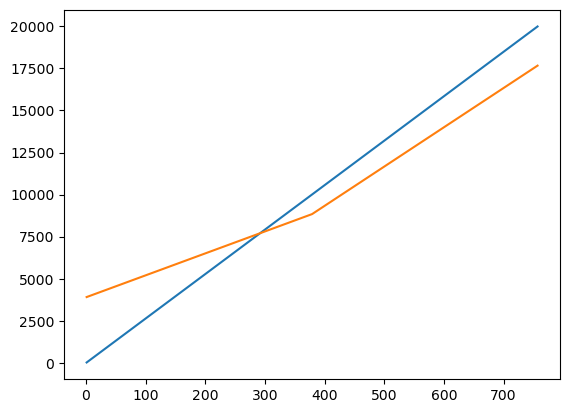

In [149]:
# Формирование расходов на 757 исков по организациям с итервлом в 1 млн. исков
group = 'организации'
max_lawsuit = 757
index_true = [75, 150, 225,
              300, 375, 450,
              525, 600, 675, 757]

creat_costs(group, max_lawsuit, index_true)

Лист: ГР_9000028ис_9(1000000-9000000)


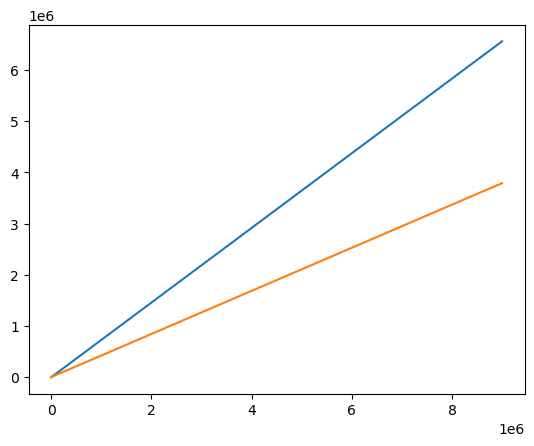

In [152]:
# Формирование расходов на 9 млн. исков по гражданам с интервалом 1 млн.
group = 'граждане'
max_lawsuit = 9000028
index_true = [x for x in range(1000000, max_lawsuit + 1, 1000000)]

creat_costs(group, max_lawsuit, index_true)

Лист: ОР_131000ис_8733(15-130995)


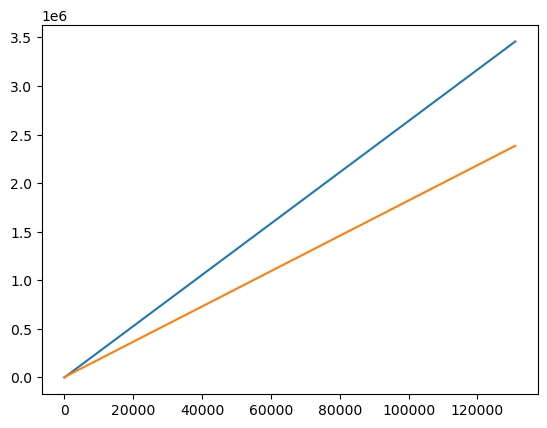

In [153]:
# Формирование расходов на 131 тыс. исков по организациям с интервалом 15
group = 'организации'
max_lawsuit = 131000
index_true = [x for x in range(15, max_lawsuit + 1, 15)]

creat_costs(group, max_lawsuit, index_true)

Лист: ГР_1000000ис_10(100000-1000000)


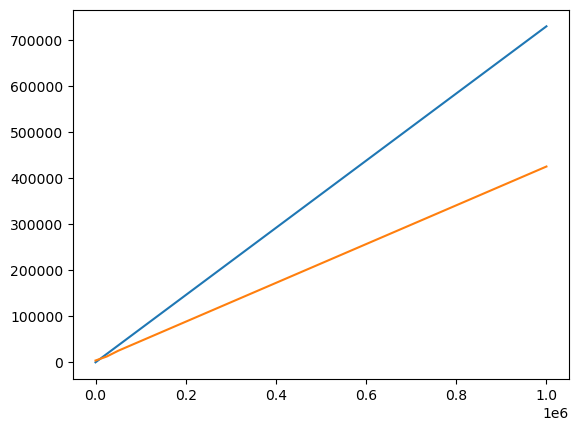

In [154]:
# Формирование расходов на 1 млн. исков по гражданам с интервалом 100 тыс.
group = 'граждане'
max_lawsuit = 1000000
index_true = [x for x in range(100000, max_lawsuit + 1, 100000)]

creat_costs(group, max_lawsuit, index_true)

Лист: ОР_15000ис_15(1000-15000)


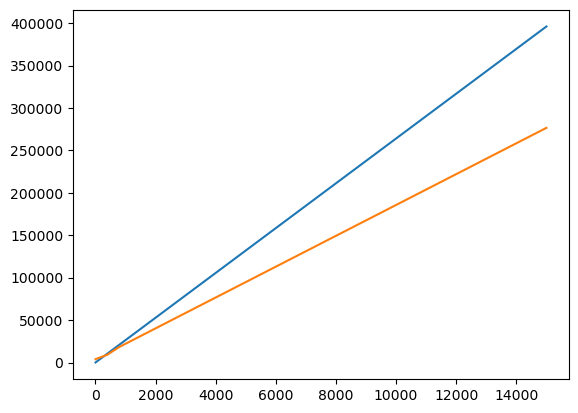

In [155]:
# Формирование расходов на 15 тыс. исков по организациям с интервалом в 1 тыс.
group = 'организации'
max_lawsuit = 15000
index_true = [x for x in range(1000, max_lawsuit + 1, 1000)]

creat_costs(group, max_lawsuit, index_true)